# Context Extraction Error Rate

In [1]:
# autoreload for development; remove later :)
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import utils as utils
import context_utils as ctutils
import data_loader as data

In [3]:
# load json files from data folder
data = data.load_data()

if len([dr for dr in data.datarecords if dr.context is None]) > 0:
    print('Warning: missing context file for files', [dr.name for dr in data.datarecords if dr.context is None])

## Labelled Data
Statistics about our data labels used for the following calculations

In [4]:
intents = utils.flatten([l['intent'] for l in data.labels])
intentsSet = set(intents)

intentCounts = {}
for intent in intentsSet:
    intentCounts[intent] = intents.count(intent)

airlines = [l['airline'] for l in data.labels if l['airline']]
airlinesSet = set(airlines)
callsigns = [l['airline'] +' '+ l['flightnr'] for l in data.labels if l['airline'] and l['flightnr']]
callsignsSet = set(callsigns)

#airlineCounts = {}
#for airline in airlinesSet:
#    airlineCounts[airline] = airlines.count(airline)
#callsignCounts = {}
#for callsign in callsignsSet:
#    callsignCounts[callsign] = callsigns.count(callsign)

print('# labelled intents:\t\t', len(intentsSet), '\t', intentsSet)
print('# labelled messages:\t\t', len(data.labels), '\t', intentCounts)
print()
print('# single-intent messages:\t', len([l['intent'] for l in data.labels if len(l['intent']) == 1]))
print('# two-intent messages:\t\t', len([l['intent'] for l in data.labels if len(l['intent']) == 2]))
print()
print('# labelled airlines:\t\t', len(airlinesSet), '\tused in', len(airlines), 'messages')
print('# labelled callsigns:\t\t', len(callsignsSet), '\tused in', len(callsigns), 'messages')

# labelled intents:		 4 	 {'flightlevel', 'turn', 'contact', 'squawk'}
# labelled messages:		 102 	 {'flightlevel': 26, 'turn': 26, 'contact': 26, 'squawk': 26}

# single-intent messages:	 100
# two-intent messages:		 2

# labelled airlines:		 38 	used in 98 messages
# labelled callsigns:		 76 	used in 98 messages


### Airline Distribution
Distribution of airline names over the labeled data

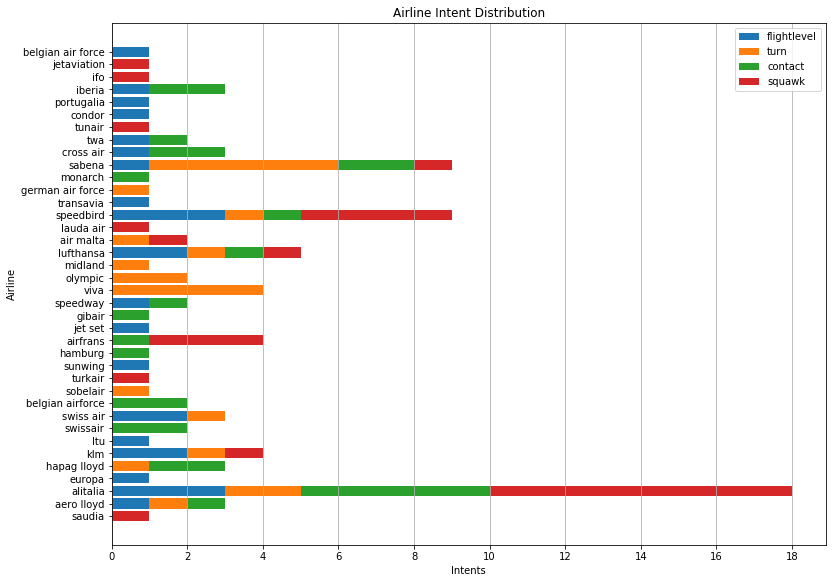

In [5]:
#airlines = [l['airline'] for l in data.labels if l['airline']]
#airlinesSet = set(airlines)

plt.figure(figsize=(12.8,9.6))
plt.subplot()

x_pos = [x for x, _ in enumerate(airlinesSet)]

countOffset = [0 for _ in airlinesSet]

for intent in intentsSet:
    airlinesIntent = [l['airline'] for l in data.labels if intent in l['intent']]
    airlinesIntentCount = [airlinesIntent.count(a) for a in airlinesSet]
    
    plt.barh(x_pos, airlinesIntentCount, label=intent, left=countOffset)
    
    countOffset = [a + b for a,b in zip(countOffset, airlinesIntentCount)] # add counts


plt.ylabel('Airline')
plt.xlabel('Intents')
plt.title('Airline Intent Distribution')
plt.legend(loc='best')

plt.gca().xaxis.get_major_locator().set_params(integer=True)
plt.xticks(np.arange(0, max(countOffset)+1, 2.0))

plt.grid(axis='x')
plt.xticks()
plt.yticks(x_pos, airlinesSet)

plt.show()

## Speech To Text


In [6]:
# todo
# vergleich von n-best; wie stark unterscheiden sich die 3 varianten überhaupt?
# (WER vergleich zu Orginaltranskription)

# 3 mal das vorhandene WER diagramm nebeneinander als subplot
# gibt auch einen output als tabelle davon (zurzeti in text file geoutputet)
# optional: 3 balken mit gesamt WER

## LUIS

In [7]:
# Versionsvergleich
# drei mal "Sensitivity and Specificity" nebeneinander
# oder noch eher: als stacked diagramm

# Confidence vergleich mit gleichem Diagramm, aber statt Count durchschnittliche Confidence

## RML
Validierung der Intent Erkennung

_Als Input dient die von Speech To Text erkannte Message (bestes Resultat)_

In [8]:
#intents = utils.flatten([l['intent'] for l in data.labels])
intents = list(set(intents))


# TODO: anzahl richtige vs falsche intent erkennungen
# TODO: anzahl richtige vs falsche callsign erkennungen (differenzierung airline & flightnumber)

callsignResults = {
    'field': ['Full CallSign', 'Airline', 'Flightnumber'],
    'valid': [0, 0, 0],
    'invalid': [0, 0, 0],
}

# valid:   alle Intents einer Message wurden korrekt erkannt
# invalid: mind. ein Intent einer Message wurde falsch erkannt
intentResults = {
    'valid': [0],
    'invalid': [0],
}

# truepos:  True Positive  -> Intent vorhanden und (korrekt) erkannt
# trueneg:  True Negative  -> Intent nicht vorhanden und (korrekt) nicht erkannt
# falsepos: False Positive -> Intent nicht vorhanden aber erkannt
# falseneg: False Negative -> Intent vorhanden aber nicht erkannt
perIntentResults = {
    'intent': intents,
    'truepos': [0 for i in intents],
    'trueneg': [0 for i in intents],
    'falsepos': [0 for i in intents],
    'falseneg': [0 for i in intents],
}

for rec in data.datarecords:
    if rec.context is None:
        continue
    
    rmlContext = rec.context[0]['RmlContext'] # 0 -> use best speech2text result only
    
    # compare extracted data with labels
    rmlAirlineValid, rmlFlightnrValid, rmlAirlineHamming, rmlFlightnrHamming = ctutils.check_callsign(rmlContext, rec.label)
    rmlIntentsValid, rmlDetectedIntents, rmlMissingIntents, rmlRedundantIntents = ctutils.check_intents(rmlContext, rec.label)
    
    # set callsignResults
    callsignResults['valid' if rmlAirlineValid and rmlFlightnrValid else 'invalid'][0] += 1
    callsignResults['valid' if rmlAirlineValid else 'invalid'][1] += 1
    callsignResults['valid' if rmlFlightnrValid else 'invalid'][2] += 1
    # set intentResults
    intentResults['valid' if rmlIntentsValid else 'invalid'][0] += 1
    
    # set perIntentResults
    for i in range(len(intents)):
        if intents[i] in rmlMissingIntents:
            perIntentResults['falseneg'][i] += 1
        elif intents[i] in rmlRedundantIntents:
            perIntentResults['falsepos'][i] += 1
        elif intents[i] in rmlDetectedIntents:
            perIntentResults['truepos'][i] += 1
        else:
            perIntentResults['trueneg'][i] += 1
            

### CallSign Extraction
Count of fully recognized callsigns and correctly recognized airline names or flight numbers

In [9]:
pd.DataFrame(callsignResults)

,field,valid,invalid
0,Full CallSign,67,35
1,Airline,79,23
2,Flightnumber,89,13


In [19]:
# Zutaten Kuchen:
# 100g Full Callsign Korrekt
# 75g  Nur Flugnummer korrekt
# 50g  Nur Airline Korrekt
# 1 EL Ungültig

# TODO: 
# Callsign Valid | Callsign Invalid
# -              | Airline Invalid / Flightnr Invalid / Both Invalid
# als stacked bar chart




### Intent Recognition
Count of messages where all intents were recognized correctly

In [11]:
pd.DataFrame(intentResults)

,valid,invalid
0,85,17


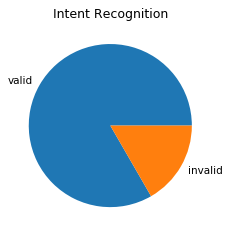

In [12]:
plt.figure(figsize=(4.8, 3.6), dpi=75)
plt.subplot()

labels = [k for k in intentResults.keys()]
values = [r[0] for  r in intentResults.values()]

plt.pie(values, labels=labels)
plt.title('Intent Recognition')
plt.show()

Sensitivity and Specificity of the intent recognition

In [13]:
pd.DataFrame(perIntentResults)

,intent,truepos,trueneg,falsepos,falseneg
0,flightlevel,26,73,3,0
1,turn,15,76,0,11
2,contact,24,76,0,2
3,squawk,24,76,0,2


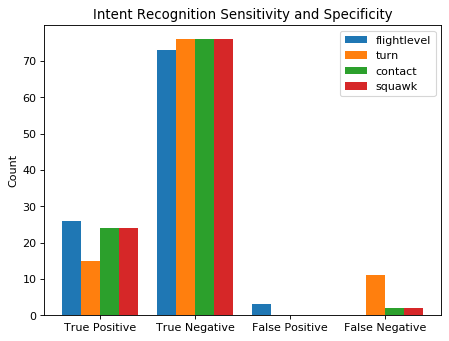

In [14]:
plt.figure(figsize=(6.4, 4.8), dpi=80)
plt.subplot()

N = 4

ind = np.arange(N) 
width = 0.2

for i in range(len(perIntentResults['intent'])):
    intentValues = [perIntentResults[c][i] for c in ['truepos','trueneg','falsepos','falseneg']]
    plt.bar(ind + (width * i), intentValues, width, label=perIntentResults['intent'][i])

plt.ylabel('Count')
plt.title('Intent Recognition Sensitivity and Specificity')

plt.xticks(ind + 1.5 * width, ('True Positive', 'True Negative', 'False Positive', 'False Negative'))
plt.legend(loc='best')
plt.show()

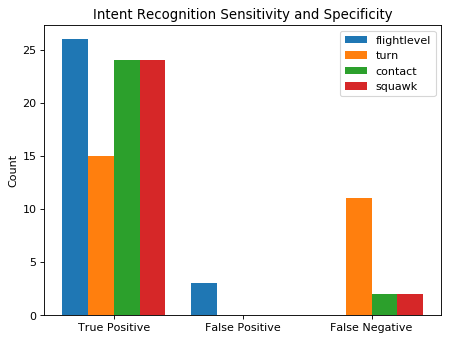

In [15]:
plt.figure(figsize=(6.4, 4.8), dpi=80)
plt.subplot()

N = 3

ind = np.arange(N) 
width = 0.2

for i in range(len(perIntentResults['intent'])):
    intentValues = [perIntentResults[c][i] for c in ['truepos','falsepos','falseneg']]
    plt.bar(ind + (width * i), intentValues, width, label=perIntentResults['intent'][i])

plt.ylabel('Count')
plt.title('Intent Recognition Sensitivity and Specificity')

plt.xticks(ind + 1.5 * width, ('True Positive', 'False Positive', 'False Negative'))
plt.legend(loc='best')
plt.show()

In [20]:
#plt.figure(figsize=(6.4, 4.8), dpi=80)
#plt.subplot()
#
#N = len(perIntentResults['intent'])
#
#ind = np.arange(N) 
#width = 0.2
#
#categoryKeys = ['truepos','trueneg','falsepos','falseneg']
#categoryLabels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
#
#for c in range(len(categoryKeys)):
#    categoryValues = [perIntentResults[categoryKeys[c]][i] for i in range(len(perIntentResults['intent']))]
#    plt.bar(ind + (width * c), categoryValues, width, label=categoryLabels[c])
#    
##plt.bar(ind, men_means, width, label='Men')
##plt.bar(ind + width, women_means, width, label='Women')
#
#plt.ylabel('Count')
#plt.title('Intent Recognition Sensitivity and Specificity')
#
#plt.xticks(ind + 1.5 * width, perIntentResults['intent'])
#plt.legend(loc='best')
#print('"Same" diagram, but different')
#plt.show()

In [17]:
# TODO: ein plot mit Intents Erfolgreich (True) gegenübergestellt mit Intents Fehlerhaft (False) - evtl Balken oder double-Pie


## LUIS vs RML

## Auswertung

In [18]:
# todo: auswertung mit theoretischem Flugraum